#Purpose

Building a binary classification model to detect which text messages are spam or not (aka Ham)

# Data

This a text data downloaded from UCI datasets. It contains 5574 SMS phone messages. 

# Method

- Long Short Term Memory (LSTM)
- Bi-directional LSTM
- GRU

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional 


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/kenneth-lee-ch/SMS-Spam-Classification/master/spam.csv', encoding='ISO-8859-1')

In [ ]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df = df[['v1','v2']]

In [ ]:
df.rename(columns={'v1':'label', 'v2':'message'}, inplace=True)

In [ ]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
duplicatedRow = df[df.duplicated()]
print(duplicatedRow[:5])

    label                                            message
102   ham  As per your request 'Melle Melle (Oru Minnamin...
153   ham  As per your request 'Melle Melle (Oru Minnamin...
206   ham  As I entered my cabin my PA said, '' Happy B'd...
222   ham                             Sorry, I'll call later
325   ham                   No calls..messages..missed calls


In [ ]:
len(duplicatedRow)

403

In [ ]:
df.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

## WordCloud

In [ ]:
# get all the ham and spam emails
ham_msg = df[df.label =='ham']
spam_msg = df[df.label=='spam']

In [ ]:
# For ham and spam messages, create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

To visualize using WordCloud, we now extract words most commonly found in ham and spam messages, remove meaningless word such as the, a...stop words and plot it. The WordCloud visualizes the most frequent words in the given text.

#### Visualize ham msg

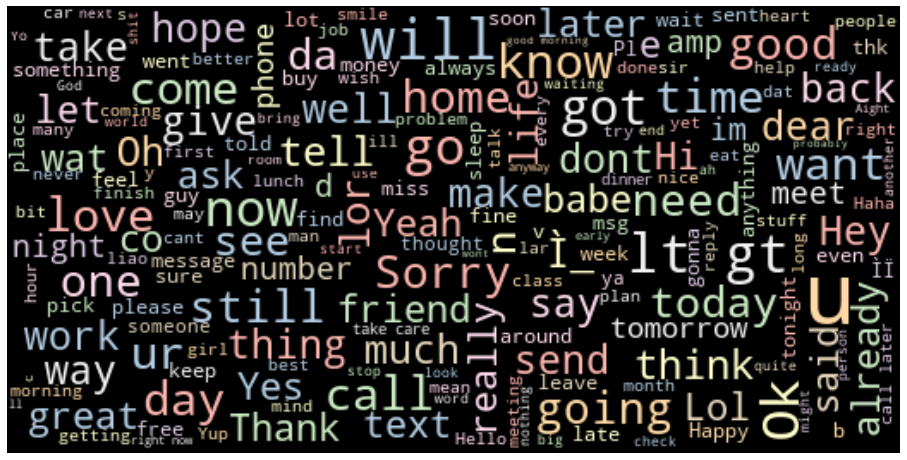

In [ ]:
ham_msg_cloud = WordCloud(width =520,
                          height =260,
                          stopwords=STOPWORDS,
                          max_font_size=50, 
                          background_color ="black",
                          colormap='Pastel1').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

The words that the most commonly appeared word in ham message from WordCloud above -> shows that words : now, work, How, Ok, Sorry etc.

#### Visualize spam msg

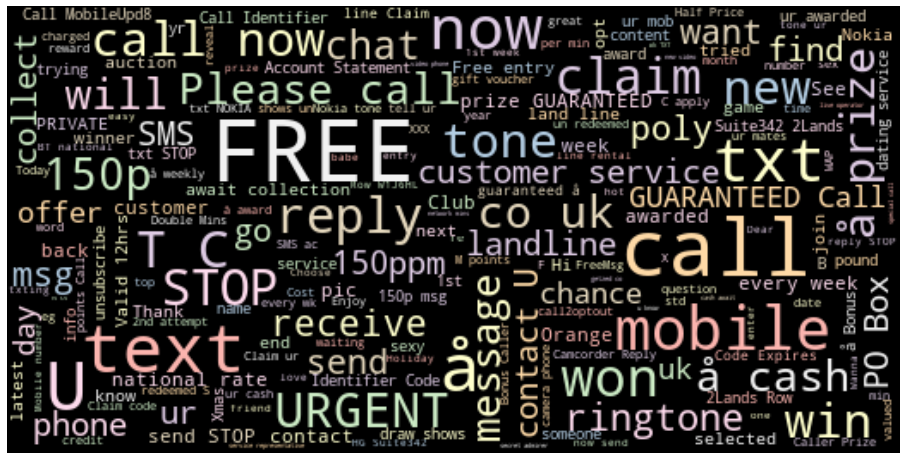

In [ ]:
spam_msg_cloud = WordCloud(width =520,
                          height =260,
                          stopwords=STOPWORDS,
                          max_font_size=50, 
                          background_color ="black",
                          colormap='Pastel1').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

The words that the most commonly appeared word in ham message from WordCloud above -> shows that words : FREE, call, text, claim, reply etc.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'The distribution of ham and spam messages')

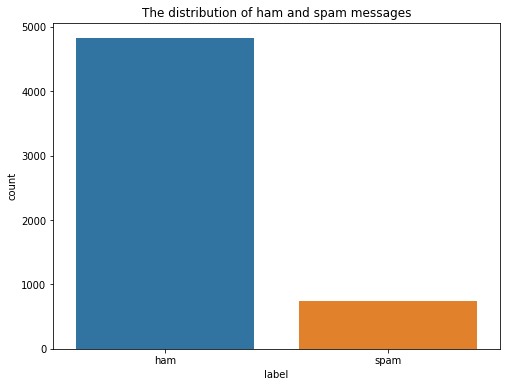

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(df.label)
plt.title('The distribution of ham and spam messages')

In [ ]:
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100

15.481865284974095

There are several ways to handle the imbalance data:
- use of appropriate evaluation metrics
- resampling the training set : oversampling/upsampling or undersampling/downsampling
- ensemble different resample datasets

In this project we use **undersampling** method.

**Undersampling** is the process where you randomly delete some of the observations from the majority class so that the numbers in majority and minority classes are matched.

In [ ]:
# downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg

In [ ]:
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


In [ ]:
# Create a dataframe with these ham and spam msg

msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Messages Types')

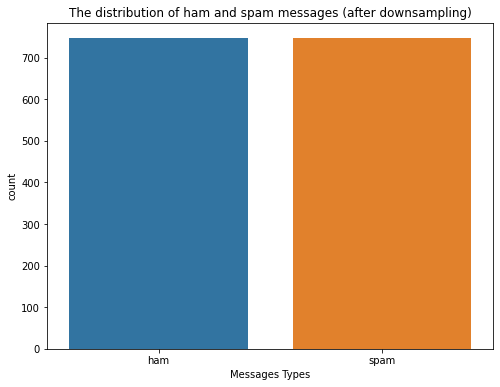

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(msg_df.label)
plt.title('The distribution of ham and spam messages (after downsampling)')
plt.xlabel('Messages Types')

We further explored length of each of the text by lable types. 
On average:
- the ham message has length of 73 words
- the spam message has length of 138 words

In [ ]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)

#Calculate average length by label types
labels = msg_df.groupby('label').mean()
labels

,text_length
label,
ham,69.626506
spam,138.866131


# Text Pre-processing

### Convert the text label to numeric

In [ ]:
msg_df['msg_type'] = msg_df['label'].map({'ham':0, 'spam':1})
msg_label = msg_df['msg_type'].values

In [ ]:
msg_df.head()

,label,message,text_length,msg_type
0,ham,"Yes, princess. Toledo.",22,0
1,ham,Dude while were makin those weirdy brownies my...,88,0
2,ham,"Hiya, sorry didn't hav signal. I haven't seen ...",169,0
3,ham,Then u ask darren go n pick u lor... But i oso...,74,0
4,ham,Lol no. I just need to cash in my nitros. Hurr...,75,0


### Train Test Split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

Text Pre-processing:
- Tokenization
- Sequencing
- Padding

### Tokenization

We need to convert the text data into numerical representation, so the model can understand that. For this purpose, a first step is Tokenization. The Tokenizer API from TensorFlow Keras splits sentences into words and encodes these into integers.



The steps are:
- tokenize into word or character
- num_words for maximum number of unique tokens
- filter out punctuation terms
- convert all words to lower case
- convert all words to integer index

In [ ]:
# Defining pre-processing hyperparameters

max_len = 50 # pad_sequencs parameter, it indicates we are only going to look for 50 words in a sentence
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 500

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size,
                      char_level = False,
                      oov_token = oov_tok)

tokenizer.fit_on_texts(x_train)

- `num_words` : indicate how many unique word you want to load in training and testing data
- `oov_token` : out of vocabulary token will be added to word index in the corpus which is used to build the model. This is used to replace out of vocabulary words (words that are not in our corpus) during text_to_sequence calls

In [ ]:
# Get the word_index

word_index = tokenizer.word_index
#word_index

In [ ]:
# check how many words
total_words = len(word_index)
total_words

4054

### Sequence and Padding


- Once tokenization is done, let's represent each sentence by **sequences** of numbers using `texts_to_sequences` from tokenizer object. 
- After that, we padded the sequence so that we can have same length of each sequence.

In [ ]:
# Train data
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

In [ ]:
# Test data
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

- padding = 'pre' or 'post (default pre). By using pre, we'll pad before each sequence and post will pad after each sequence
- maxlen = maximum length of all sequences. If not provided, by default it will use the maximum length of the longest sentence
- truncating = 'pre' or 'post' (default 'pre'). If a sequence length is larger than the provided maxlen value then, these values will be truncated to maxlen. 'pre' option will truncate at the beginning where as 'post' will truncate at the end of the sequences.

In [ ]:
# Shape of training and testing tensor

print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [ ]:
len(training_sequences[0]), len(training_sequences[1])

(27, 24)

In [ ]:
len(training_padded[0]), len(training_padded[1])

(50, 50)

In [ ]:
print(training_padded[0])

[  1  37 200   8  31   1   3  24   1   2 241   2   7 148 264 127  31  10
  15   6   7  31 241  87  15  19   1   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


# Train the Model

**1. The first layer**
- embedding layer : maps each word to a N-dimensional vector of real numbers. The `embeding_dim` = 16 (the size of this vector).
- the embeding layer indicates that the two words with similar meaning tend to have very close vectors.
- Because, the embedding layer is the first hidden layer in the model network, we need to pass shape of our input layer as defined by `input_length` (max_len =50).

**2. The pooling layer**
- helps to reduce the number of parameters in the model hence helps to avoid overfitting.
- we have used average pooling here and coverted layer to 1 dimension

**3. The dense layer**
- a dense layer with activation function `'relu'` followed by a dropout layer to avoid overfitting.
- a final outpout layer with sigmoid activation function.The sigmoid activation function outputs probabilities between 0 and 1.

#1. Dense Model

In [ ]:
vocab_size = 500
embedding_dim = 16
drop_value = 0.2
n_dense = 24

In [ ]:
# Define Dense Model Architecture
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
______________________________________________________

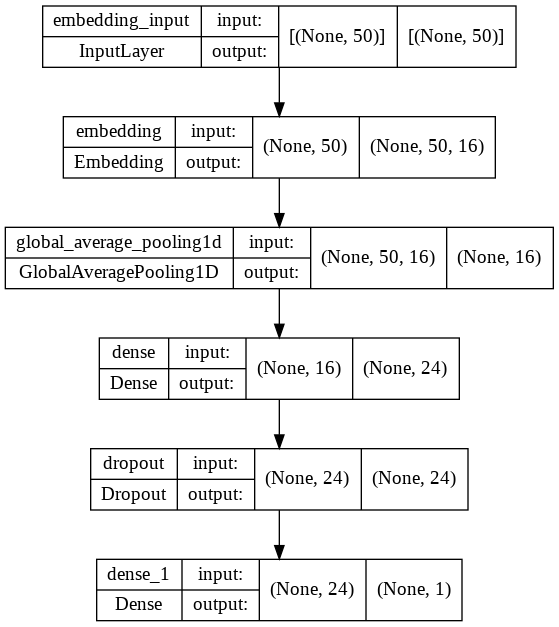

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [ ]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded,
                    y_train,
                    epochs=num_epochs, 
                    validation_data=(testing_padded, y_test),
                    callbacks =[early_stop],
                    verbose=2)

Epoch 1/30
38/38 - 8s - loss: 0.6859 - accuracy: 0.7498 - val_loss: 0.6775 - val_accuracy: 0.7726 - 8s/epoch - 198ms/step
Epoch 2/30
38/38 - 0s - loss: 0.6610 - accuracy: 0.8452 - val_loss: 0.6439 - val_accuracy: 0.8194 - 265ms/epoch - 7ms/step
Epoch 3/30
38/38 - 0s - loss: 0.6081 - accuracy: 0.8653 - val_loss: 0.5766 - val_accuracy: 0.8462 - 263ms/epoch - 7ms/step
Epoch 4/30
38/38 - 0s - loss: 0.5248 - accuracy: 0.8787 - val_loss: 0.4923 - val_accuracy: 0.8562 - 265ms/epoch - 7ms/step
Epoch 5/30
38/38 - 0s - loss: 0.4374 - accuracy: 0.8887 - val_loss: 0.4127 - val_accuracy: 0.8696 - 282ms/epoch - 7ms/step
Epoch 6/30
38/38 - 0s - loss: 0.3615 - accuracy: 0.8996 - val_loss: 0.3501 - val_accuracy: 0.8796 - 339ms/epoch - 9ms/step
Epoch 7/30
38/38 - 0s - loss: 0.3020 - accuracy: 0.9121 - val_loss: 0.2962 - val_accuracy: 0.8997 - 313ms/epoch - 8ms/step
Epoch 8/30
38/38 - 0s - loss: 0.2622 - accuracy: 0.9222 - val_loss: 0.2547 - val_accuracy: 0.9097 - 265ms/epoch - 7ms/step
Epoch 9/30
38/38 

In [ ]:
model.evaluate(testing_padded, y_test)

10/10 [==============================] - 0s 10ms/step - loss: 0.0873 - accuracy: 0.9599


[0.08726780116558075, 0.9598662257194519]

In [ ]:
metrics = pd.DataFrame(history.history)

In [ ]:
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
metrics[:2]

,Training_Loss,Training_Accuracy,Validation_Loss,Validation_Accuracy
0,0.685873,0.749791,0.677516,0.772575
1,0.661039,0.845188,0.643905,0.819398


In [ ]:
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Dense Classifier: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

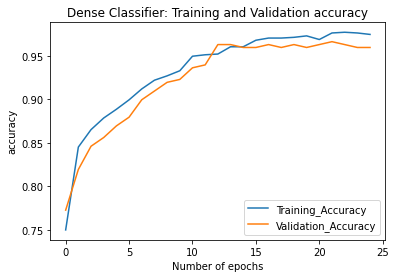

In [ ]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

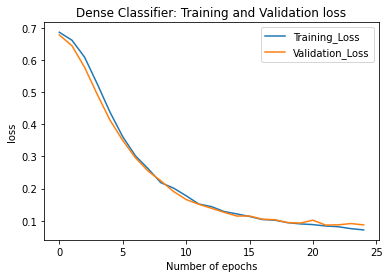

In [ ]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

In [ ]:
train_dense_results = model.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

5/5 - 0s - loss: 0.0649 - accuracy: 0.9774 - 43ms/epoch - 9ms/step
2/2 - 0s - loss: 0.0873 - accuracy: 0.9599 - 26ms/epoch - 13ms/step
Train accuracy: 97.74
Valid accuracy: 95.99


#2. Long Short Term Memory (LSTM)

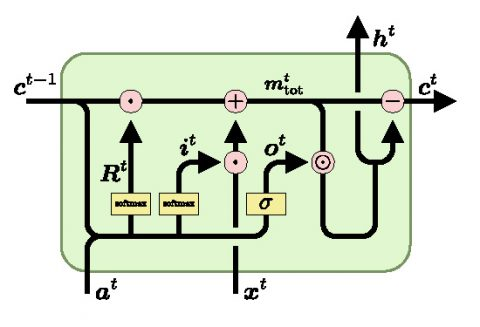

- `SpatialDropout1D` :  is used to dropout our embedding layer by using drop_embed = 0.2. The SpatialDropout1D helps to drop entire 1D feature maps instead of individual elements.
- `n_lstm` = 128 is the number of nodes in the hidden layers within the LSTM cell.
- `return_sequences` = True ensures that the LSTM cell returns all of the outputs from the unrolled LSTM cell through time. If this argument is not used, the LSTM cell will simply provide the output of the LSTM cell from the previous step.

In [ ]:
# Define parameter

n_lstm = 128
drop_lstm = 0.2

In [ ]:
# Define LSTM Model 
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model1.add(SpatialDropout1D(drop_lstm))
model1.add(LSTM(n_lstm, return_sequences=False))
model1.add(Dropout(drop_lstm))
model1.add(Dense(1, activation='sigmoid'))

In [ ]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            8000      
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 50, 16)           0         
 lDropout1D)                                                     
                                                                 
 lstm (LSTM)                 (None, 128)               74240     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 82,369
Trainable params: 82,369
Non-trainable params: 0
__________________________________________________

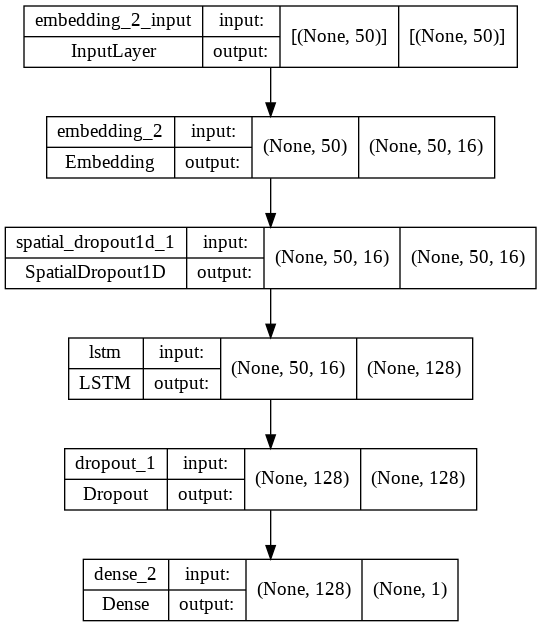

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model1, show_shapes=True, show_layer_names=True)

In [ ]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model1.fit(training_padded,
                     y_train,
                     epochs=num_epochs, 
                     validation_data=(testing_padded, y_test),
                     callbacks =[early_stop],
                     verbose=2)

Epoch 1/30
38/38 - 5s - loss: 0.6603 - accuracy: 0.5690 - val_loss: 0.4202 - val_accuracy: 0.8629 - 5s/epoch - 120ms/step
Epoch 2/30
38/38 - 0s - loss: 0.3404 - accuracy: 0.8695 - val_loss: 0.2315 - val_accuracy: 0.9130 - 236ms/epoch - 6ms/step
Epoch 3/30
38/38 - 0s - loss: 0.1760 - accuracy: 0.9389 - val_loss: 0.1123 - val_accuracy: 0.9632 - 283ms/epoch - 7ms/step
Epoch 4/30
38/38 - 0s - loss: 0.1134 - accuracy: 0.9632 - val_loss: 0.0776 - val_accuracy: 0.9766 - 271ms/epoch - 7ms/step
Epoch 5/30
38/38 - 0s - loss: 0.1090 - accuracy: 0.9615 - val_loss: 0.1534 - val_accuracy: 0.9699 - 272ms/epoch - 7ms/step
Epoch 6/30
38/38 - 0s - loss: 0.0948 - accuracy: 0.9715 - val_loss: 0.0948 - val_accuracy: 0.9699 - 233ms/epoch - 6ms/step


In [ ]:
metrics = pd.DataFrame(history.history)
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)

In [ ]:
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

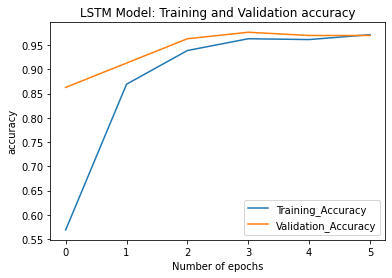

In [ ]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

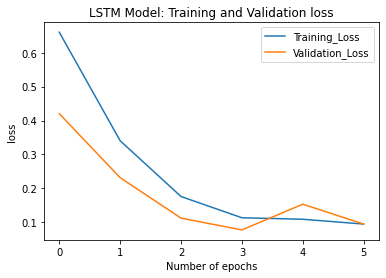

In [ ]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

In [ ]:
train_lstm_results = model1.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_lstm_results = model1.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_lstm_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_lstm_results[1]*100:0.2f}')

5/5 - 0s - loss: 0.0667 - accuracy: 0.9841 - 33ms/epoch - 7ms/step
2/2 - 0s - loss: 0.0948 - accuracy: 0.9699 - 19ms/epoch - 10ms/step
Train accuracy: 98.41
Valid accuracy: 96.99


# 3. Bidirectional LSTM (Bi-LSTM)

- The Bi-LSTM learns patterns from both before and after a given token within a document. 
- The Bi-LSTM backpropagates in both backward and forward directions in time. - Due to this, the computational time is increased compared to LSTM. 
- However, in most of the cases Bi-LSTM results in better accuracy.

In [ ]:
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim, input_length = max_len))
model2.add(Bidirectional(LSTM(n_lstm,
                              return_sequences = False)))
model2.add(Dropout(drop_lstm))
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 16)            8000      
                                                                 
 bidirectional (Bidirectiona  (None, 256)              148480    
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 156,737
Trainable params: 156,737
Non-trainable params: 0
_________________________________________________________________


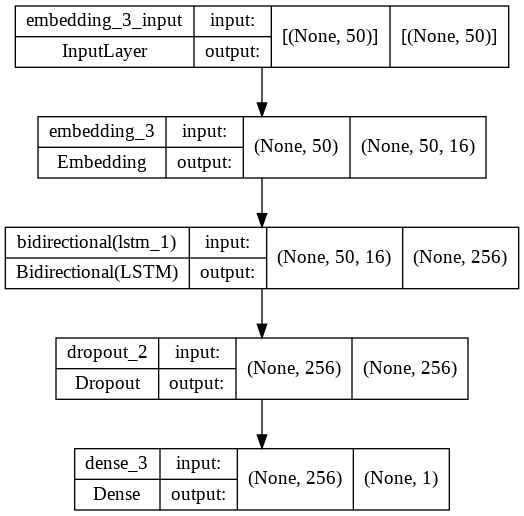

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model2, show_shapes=True, show_layer_names=True)

In [ ]:
model2.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics=['accuracy'])

In [ ]:
num_epochs = 30
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 2)
history = model2.fit(training_padded,
                     y_train,
                     epochs = num_epochs,
                     validation_data = (testing_padded, y_test),
                     callbacks = [early_stop],
                     verbose = 2)

Epoch 1/30
38/38 - 4s - loss: 0.5989 - accuracy: 0.6628 - val_loss: 0.4537 - val_accuracy: 0.8328 - 4s/epoch - 111ms/step
Epoch 2/30
38/38 - 0s - loss: 0.2456 - accuracy: 0.9172 - val_loss: 0.3263 - val_accuracy: 0.9030 - 366ms/epoch - 10ms/step
Epoch 3/30
38/38 - 0s - loss: 0.1483 - accuracy: 0.9540 - val_loss: 0.1348 - val_accuracy: 0.9632 - 341ms/epoch - 9ms/step
Epoch 4/30
38/38 - 0s - loss: 0.1168 - accuracy: 0.9657 - val_loss: 0.1292 - val_accuracy: 0.9599 - 340ms/epoch - 9ms/step
Epoch 5/30
38/38 - 0s - loss: 0.0848 - accuracy: 0.9741 - val_loss: 0.0632 - val_accuracy: 0.9766 - 343ms/epoch - 9ms/step
Epoch 6/30
38/38 - 0s - loss: 0.0667 - accuracy: 0.9782 - val_loss: 0.0814 - val_accuracy: 0.9799 - 337ms/epoch - 9ms/step
Epoch 7/30
38/38 - 0s - loss: 0.0533 - accuracy: 0.9841 - val_loss: 0.0837 - val_accuracy: 0.9732 - 350ms/epoch - 9ms/step


In [ ]:
metrics = pd.DataFrame(history.history)

metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)

In [ ]:
metrics[:2]

,Training_Loss,Training_Accuracy,Validation_Loss,Validation_Accuracy
0,0.598871,0.662762,0.453700,0.832776
1,0.245614,0.917155,0.326285,0.903010


In [ ]:
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

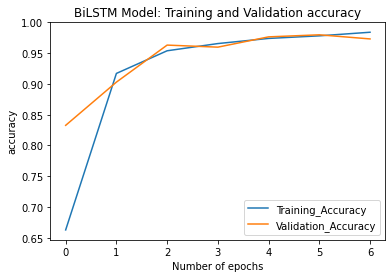

In [ ]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

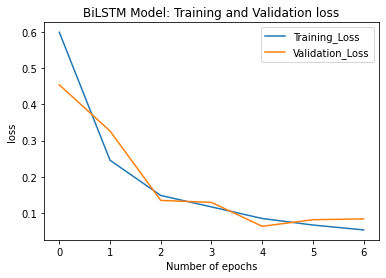

In [ ]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

In [ ]:
train_bilstm_results = model2.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_bilstm_results = model2.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_bilstm_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_bilstm_results[1]*100:0.2f}')

5/5 - 0s - loss: 0.0477 - accuracy: 0.9874 - 40ms/epoch - 8ms/step
2/2 - 0s - loss: 0.0837 - accuracy: 0.9732 - 23ms/epoch - 11ms/step
Train accuracy: 98.74
Valid accuracy: 97.32


# 4. GRU

In [ ]:
# Define GRU Model 
model3 = Sequential()
model3.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model3.add(SpatialDropout1D(0.2))
model3.add(GRU(128, return_sequences=False))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation='sigmoid'))

In [ ]:
model3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 50, 16)            8000      
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 50, 16)           0         
 lDropout1D)                                                     
                                                                 
 gru_3 (GRU)                 (None, 128)               56064     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 64,193
Trainable params: 64,193
Non-trainable params: 0
__________________________________________________

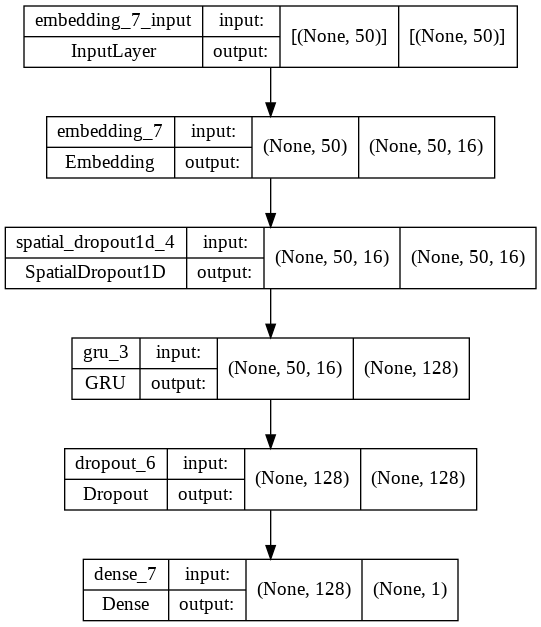

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model3, show_shapes=True, show_layer_names=True)

In [ ]:
model3.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model3.fit(training_padded,
                     y_train,
                     epochs=num_epochs, 
                     validation_data=(testing_padded, y_test),
                     callbacks =[early_stop],
                     verbose=2)

Epoch 1/30
38/38 - 2s - loss: 0.6939 - accuracy: 0.4904 - val_loss: 0.6944 - val_accuracy: 0.4816 - 2s/epoch - 61ms/step
Epoch 2/30
38/38 - 0s - loss: 0.6932 - accuracy: 0.5054 - val_loss: 0.6929 - val_accuracy: 0.5284 - 262ms/epoch - 7ms/step
Epoch 3/30
38/38 - 0s - loss: 0.6929 - accuracy: 0.5046 - val_loss: 0.6945 - val_accuracy: 0.4816 - 266ms/epoch - 7ms/step
Epoch 4/30
38/38 - 0s - loss: 0.6938 - accuracy: 0.5188 - val_loss: 0.6924 - val_accuracy: 0.5284 - 261ms/epoch - 7ms/step
Epoch 5/30
38/38 - 0s - loss: 0.6932 - accuracy: 0.4979 - val_loss: 0.6946 - val_accuracy: 0.4816 - 233ms/epoch - 6ms/step
Epoch 6/30
38/38 - 0s - loss: 0.6928 - accuracy: 0.5138 - val_loss: 0.6938 - val_accuracy: 0.4816 - 262ms/epoch - 7ms/step


In [ ]:
metrics = pd.DataFrame(history.history)
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)

In [ ]:
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('GRU Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

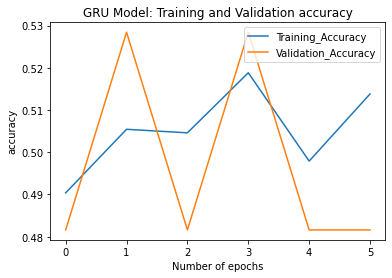

In [ ]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

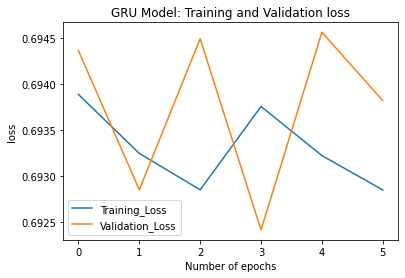

In [ ]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

In [ ]:
train_gru_results = model3.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_gru_results = model3.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_gru_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_gru_results[1]*100:0.2f}')

5/5 - 0s - loss: 0.6923 - accuracy: 0.5146 - 29ms/epoch - 6ms/step
2/2 - 0s - loss: 0.6938 - accuracy: 0.4816 - 19ms/epoch - 10ms/step
Train accuracy: 51.46
Valid accuracy: 48.16


# Comparing the four different models

In [ ]:
# Comparing four different models
print(f"Dense model loss and accuracy: {model.evaluate(testing_padded, y_test)} " )
print(f"LSTM model loss and accuracy: {model1.evaluate(testing_padded, y_test)} " )
print(f"Bi-LSTM model loss and accuracy: {model2.evaluate(testing_padded, y_test)} " )
print(f"GRU model loss and accuracy: {model3.evaluate(testing_padded, y_test)}")

10/10 [==============================] - 0s 2ms/step - loss: 0.0873 - accuracy: 0.9599
Dense model loss and accuracy: [0.08726780116558075, 0.9598662257194519] 
10/10 [==============================] - 0s 4ms/step - loss: 0.0948 - accuracy: 0.9699
LSTM model loss and accuracy: [0.09480885416269302, 0.9698996543884277] 
10/10 [==============================] - 0s 5ms/step - loss: 0.0837 - accuracy: 0.9732
Bi-LSTM model loss and accuracy: [0.08366090059280396, 0.9732441306114197] 
10/10 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.4816
GRU model loss and accuracy: [0.6938172578811646, 0.4816053509712219]


Based on the loss, accuracy and the plots, we can conclude if the ... is the best model for this classification case, because the ... model has validation accuracy = ... % and loss = ...

# Predict Ham or Spam for the new messages

## 1. Using raw text from the dataset 

In [ ]:
pd.options.display.max_colwidth=100
df[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...


In [ ]:
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
               "Ok lar... Joking wif u oni...",
               "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

In [ ]:
def predict_spam(predict_msg):
  new_seq = tokenizer.texts_to_sequences(predict_msg)
  padded = pad_sequences(new_seq,
                         maxlen = max_len,
                         padding = padding_type,
                         truncating = trunc_type)
  return(model.predict(padded))

In [ ]:
predict_spam(predict_msg)

array([[0.00721421],
       [0.01828883],
       [0.99967635]], dtype=float32)

## 2. Using newly created text 

In [ ]:
predict_msg = ["Have friends and colleagues who could benefit from these weekly updates? Send them to this link to subscribe",
               "Call me"]

In [ ]:
predict_spam(predict_msg)

array([[0.95050395],
       [0.03234783]], dtype=float32)

# Summary

We used the text messages from UCI datasets and fit deep learning models such as Dense architecture, LSTM and Bi-LSTM and compared the accuracy and loss on validation set across these models.

# References

- https://github.com/ShresthaSudip/SMS_Spam_Detection_DNN_LSTM_BiLSTM/blob/master/NLP_SMS_Spam_Detection_FinalVersion_Downsampling_Dense_LSTM_BiLSTM.ipynb

- https://towardsdatascience.com/nlp-spam-detection-in-sms-text-data-using-deep-learning-b8632db85cc8
